# Load and preprocess data

In [1]:
import numpy as np

train = np.load('train.npy', allow_pickle=True)
test = np.load('test.npy', allow_pickle=True)
print("train.shape=",train.shape)
print("test.shape=",test.shape)

train.shape= (10000, 32, 32, 3)
test.shape= (40000, 32, 32, 3)


# Task

这份作业要执行的task是semi-supervised anomaly detection，也就是说trainingset是干净的，testing的时候才会混进outlier data(anomaly)。
我们以某个简单的image dataset（image加上他们的label（分类））作为示范，training data为原先trainingset中的某几类，而testing data则是原先testingset的所有data，要侦测的anomaly为training data中未出现的类别。label的部分，1为outlier data而0为inlier data(相对于 outlier)。正确率以AUC计算。
方法则列举3种： KNN, PCA, Autoencoder

# Method 1: KNN

K-Nearest-Neighbor(KNN): 假设training data的label种类不多（e.g. < 20），然而因其为未知，可以猜测其为n，亦即假设training data有n群。先用K-means计算training data中的n个centroid，再用这n个centroid对training data分群。应该可以观察到，inlier data与所分到群的centroid的距离应较outlier的此距离来得小。

In [2]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import f1_score, pairwise_distances, roc_auc_score
from scipy.cluster.vq import vq, kmeans

task='knn'
if task == 'knn':
    x = train.reshape(len(train), -1)
    y = test.reshape(len(test), -1)
    scores = list()
    for n in range(1, 10):
      kmeans_x = MiniBatchKMeans(n_clusters=n, batch_size=100).fit(x)
      y_cluster = kmeans_x.predict(y)
      y_dist = np.sum(np.square(kmeans_x.cluster_centers_[y_cluster] - y), axis=1)

      y_pred = y_dist
#       score = f1_score(y_label, y_pred, average='micro')
#       score = roc_auc_score(y_label, y_pred, average='micro')
#       scores.append(score)
#     print(np.max(scores), np.argmax(scores))
#     print(scores)
#     print('auc score: {}'.format(np.max(scores)))


# Method 2: PCA

PCA:首先计算training data的principle component，将testing data投影在这些component上，再将这些投影重建回原先space的向量。对重建的图片和原图计算MSE，inlier data的数值应该较outlier的数值为小。

In [3]:
from sklearn.decomposition import PCA

task='pca'

if task == 'pca':

    x = train.reshape(len(train), -1)
    y = test.reshape(len(test), -1)
    pca = PCA(n_components=2).fit(x)

    y_projected = pca.transform(y)
    y_reconstructed = pca.inverse_transform(y_projected)  
    dist = np.sqrt(np.sum(np.square(y_reconstructed - y).reshape(len(y), -1), axis=1))
    
    y_pred = dist
#     score = roc_auc_score(y_label, y_pred, average='micro')
#     score = f1_score(y_label, y_pred, average='micro')
#     print('auc score: {}'.format(score))

# Method 3: Autoencoder

## Models & loss

fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner

conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

task = 'ae'
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 32 * 32 * 3
            ), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
    # 	    nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
    #       nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(32*32*3, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 32*32*3)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return mse + KLD


# Training

In [5]:
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)


if task == 'ae':
    num_epochs = 1000
    batch_size = 128
    learning_rate = 1e-3

    #{'fcn', 'cnn', 'vae'} 
    model_type = 'cnn' 

    x = train
    if model_type == 'fcn' or model_type == 'vae':
        x = x.reshape(len(x), -1)
        
    data = torch.tensor(x, dtype=torch.float)
    train_dataset = TensorDataset(data)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)


    model_classes = {'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE()}
    model = model_classes[model_type].cuda()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate)
    
    best_loss = np.inf
    model.train()
    for epoch in range(num_epochs):
        for data in train_dataloader:
            if model_type == 'cnn':
                img = data[0].transpose(3, 1).cuda()
            else:
                img = data[0].cuda()
            # ===================forward=====================
            output = model(img)
            if model_type == 'vae':
                loss = loss_vae(output[0], img, output[1], output[2], criterion)
            else:
                loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================save====================
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model, 'best_model_{}.pt'.format(model_type))
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, loss.item()))
        

epoch [1/1000], loss:0.0839
epoch [2/1000], loss:0.0452
epoch [3/1000], loss:0.0473
epoch [4/1000], loss:0.0365
epoch [5/1000], loss:0.0302
epoch [6/1000], loss:0.0290
epoch [7/1000], loss:0.0331
epoch [8/1000], loss:0.0248
epoch [9/1000], loss:0.0198
epoch [10/1000], loss:0.0206
epoch [11/1000], loss:0.0207
epoch [12/1000], loss:0.0262
epoch [13/1000], loss:0.0200
epoch [14/1000], loss:0.0194
epoch [15/1000], loss:0.0151
epoch [16/1000], loss:0.0190
epoch [17/1000], loss:0.0173
epoch [18/1000], loss:0.0224
epoch [19/1000], loss:0.0157
epoch [20/1000], loss:0.0156
epoch [21/1000], loss:0.0175
epoch [22/1000], loss:0.0163
epoch [23/1000], loss:0.0161
epoch [24/1000], loss:0.0179
epoch [25/1000], loss:0.0153
epoch [26/1000], loss:0.0139
epoch [27/1000], loss:0.0158
epoch [28/1000], loss:0.0147
epoch [29/1000], loss:0.0128
epoch [30/1000], loss:0.0139
epoch [31/1000], loss:0.0128
epoch [32/1000], loss:0.0135
epoch [33/1000], loss:0.0152
epoch [34/1000], loss:0.0144
epoch [35/1000], loss:0

# Evaluation

将testing的图片输入model后，可以得到其重建的图片，并对两者取平方差。可以发现inlier（原先label 0~7）的平方差应该与outlier（原先label 8,9）的平方差形成差距明显的两群数据。

In [6]:

if task == 'ae':
    if model_type == 'fcn' or model_type == 'vae':
        y = test.reshape(len(test_tmp), -1)
    else:
        y = test
        
    data = torch.tensor(y, dtype=torch.float)
    test_dataset = TensorDataset(data)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

    model = torch.load('best_model_{}.pt'.format(model_type), map_location='cuda')

    model.eval()
    reconstructed = list()
    for i, data in enumerate(test_dataloader): 
        if model_type == 'cnn':
            img = data[0].transpose(3, 1).cuda()
        else:
            img = data[0].cuda()
        output = model(img)
        if model_type == 'cnn':
            output = output.transpose(3, 1)
        elif model_type == 'vae':
            output = output[0]
        reconstructed.append(output.cpu().detach().numpy())

    reconstructed = np.concatenate(reconstructed, axis=0)
    anomality = np.sqrt(np.sum(np.square(reconstructed - y).reshape(len(y), -1), axis=1))
    y_pred = anomality
    with open('prediction.csv', 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(y_pred)):
            f.write('{},{}\n'.format(i+1, y_pred[i]))
#     score = roc_auc_score(y_label, y_pred, average='micro')
#     score = f1_score(y_label, y_pred, average='micro')
#     print('auc score: {}'.format(score))


# Visualization
# The top 5 anomalies in testing data

32139 16.10285051807307
10593 15.340178951421084
5782 11.959344009258455
23975 9.987699575361514
28503 9.469182166638072


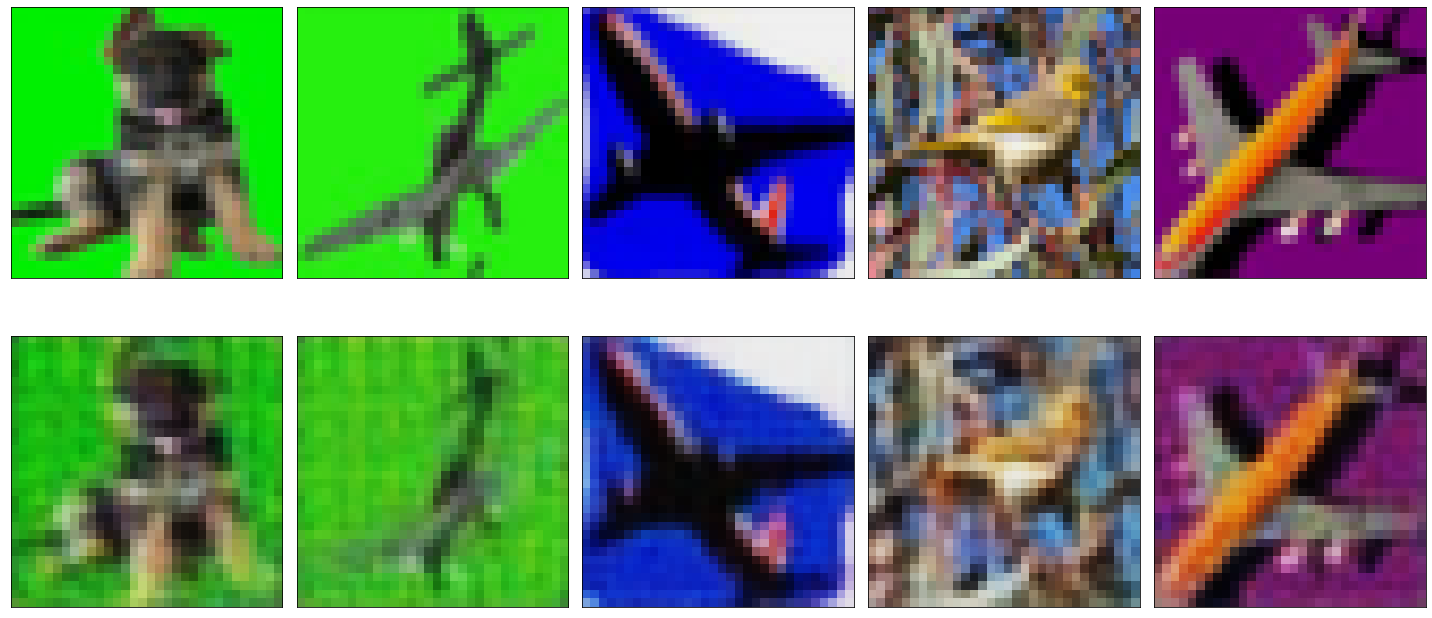

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
a=np.argsort(-y_pred)
indexes=[]
for i in range(5):
    indexes.append(a[i])
    print(a[i],y_pred[a[i]])
imgs = test[indexes,]
imgs = imgs.astype(np.float32)

for i, img in enumerate(imgs):
    plt.subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(( (img+1) * 120).astype(np.uint8))

# 画出 reconstruct 的图
inp = torch.Tensor(test[indexes,].transpose(0,3,1,2)).cuda()
recs = model(inp)
recs = recs.cpu().detach().numpy()
recs = recs.transpose(0, 2, 3, 1)
for i, img in enumerate(recs):
    plt.subplot(2, 5, 5+i+1, xticks=[], yticks=[])
    plt.imshow(( (img+1) * 120).astype(np.uint8))
  
plt.tight_layout()

# The top 5 nomalies in testing data

18555 0.9211725323655512
33914 0.9793217569827506
24220 1.0053230168895329
20206 1.017765379810692
22146 1.0190455646719643


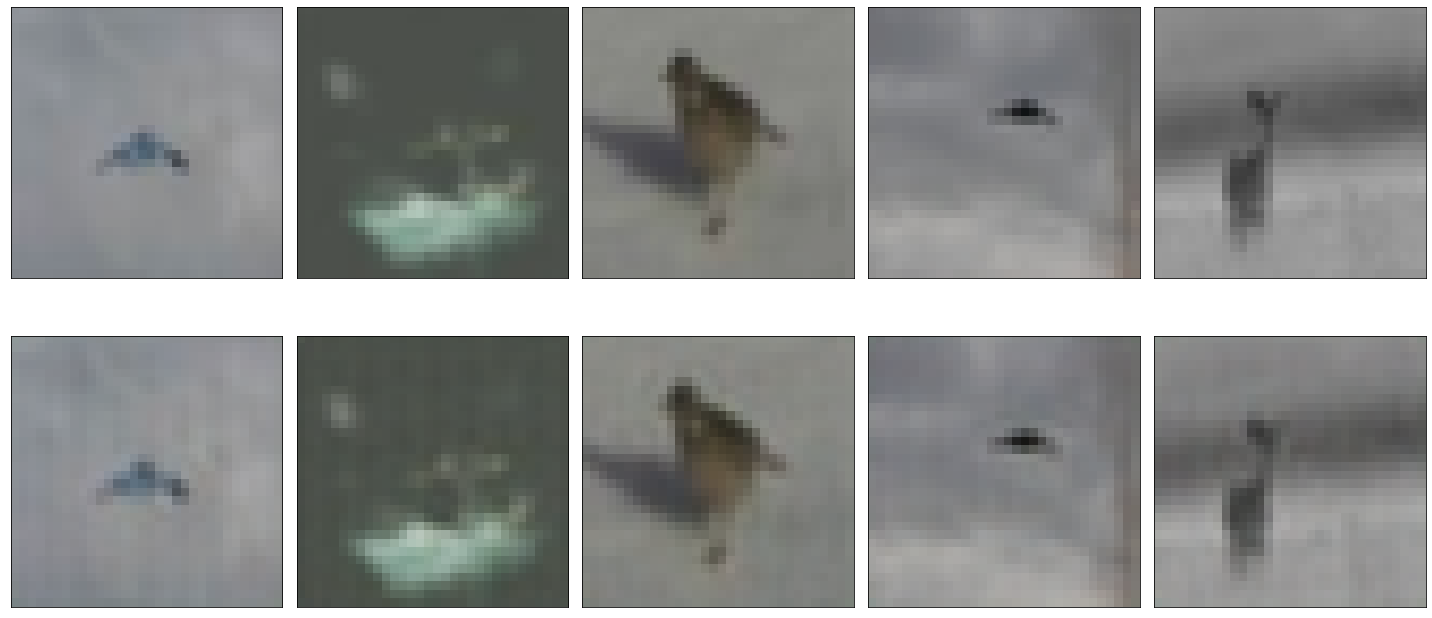

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
a=np.argsort(y_pred)
indexes=[]
for i in range(5):
    indexes.append(a[i])
    print(a[i],y_pred[a[i]])
imgs = test[indexes,]
imgs = imgs.astype(np.float32)

for i, img in enumerate(imgs):
    plt.subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(( (img+1) * 120).astype(np.uint8))

# 画出 reconstruct 的图
inp = torch.Tensor(test[indexes,].transpose(0,3,1,2)).cuda()
recs = model(inp)
recs = recs.cpu().detach().numpy()
recs = recs.transpose(0, 2, 3, 1)
for i, img in enumerate(recs):
    plt.subplot(2, 5, 5+i+1, xticks=[], yticks=[])
    plt.imshow(( (img+1) * 120).astype(np.uint8))
  
plt.tight_layout()